# Lecture 2
_____________


In [1]:
# if running on Colab, copy data from Github
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/jdherman/eci273.git
    %cd eci273

## _Load data and plot_

Define conversion factor from cfs to thousand acre-feet per day

In [2]:
cfs_to_tafd = 2.29568411*10**-5 * 86400 / 1000

We'll use the `loadtxt` function from numpy to read the CSV.

The delimiter is a comma. Other options might be tab `\t` or space `\s`.

We want to skip the header row and the first (0th) column because they contain strings

In general it's better to use the `pandas` library to load CSVs, which we'll see later

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

data = np.loadtxt('data/SHA.csv', delimiter=',',
                  skiprows=1, usecols=[1,2,3,4])

In [4]:
inflow = data[:,0] * cfs_to_tafd # TAF/d
outflow = data[:,1] * cfs_to_tafd # TAF/d
storage = data[:,2] / 1000 # AF to TAF

#### First plot: time series of storage

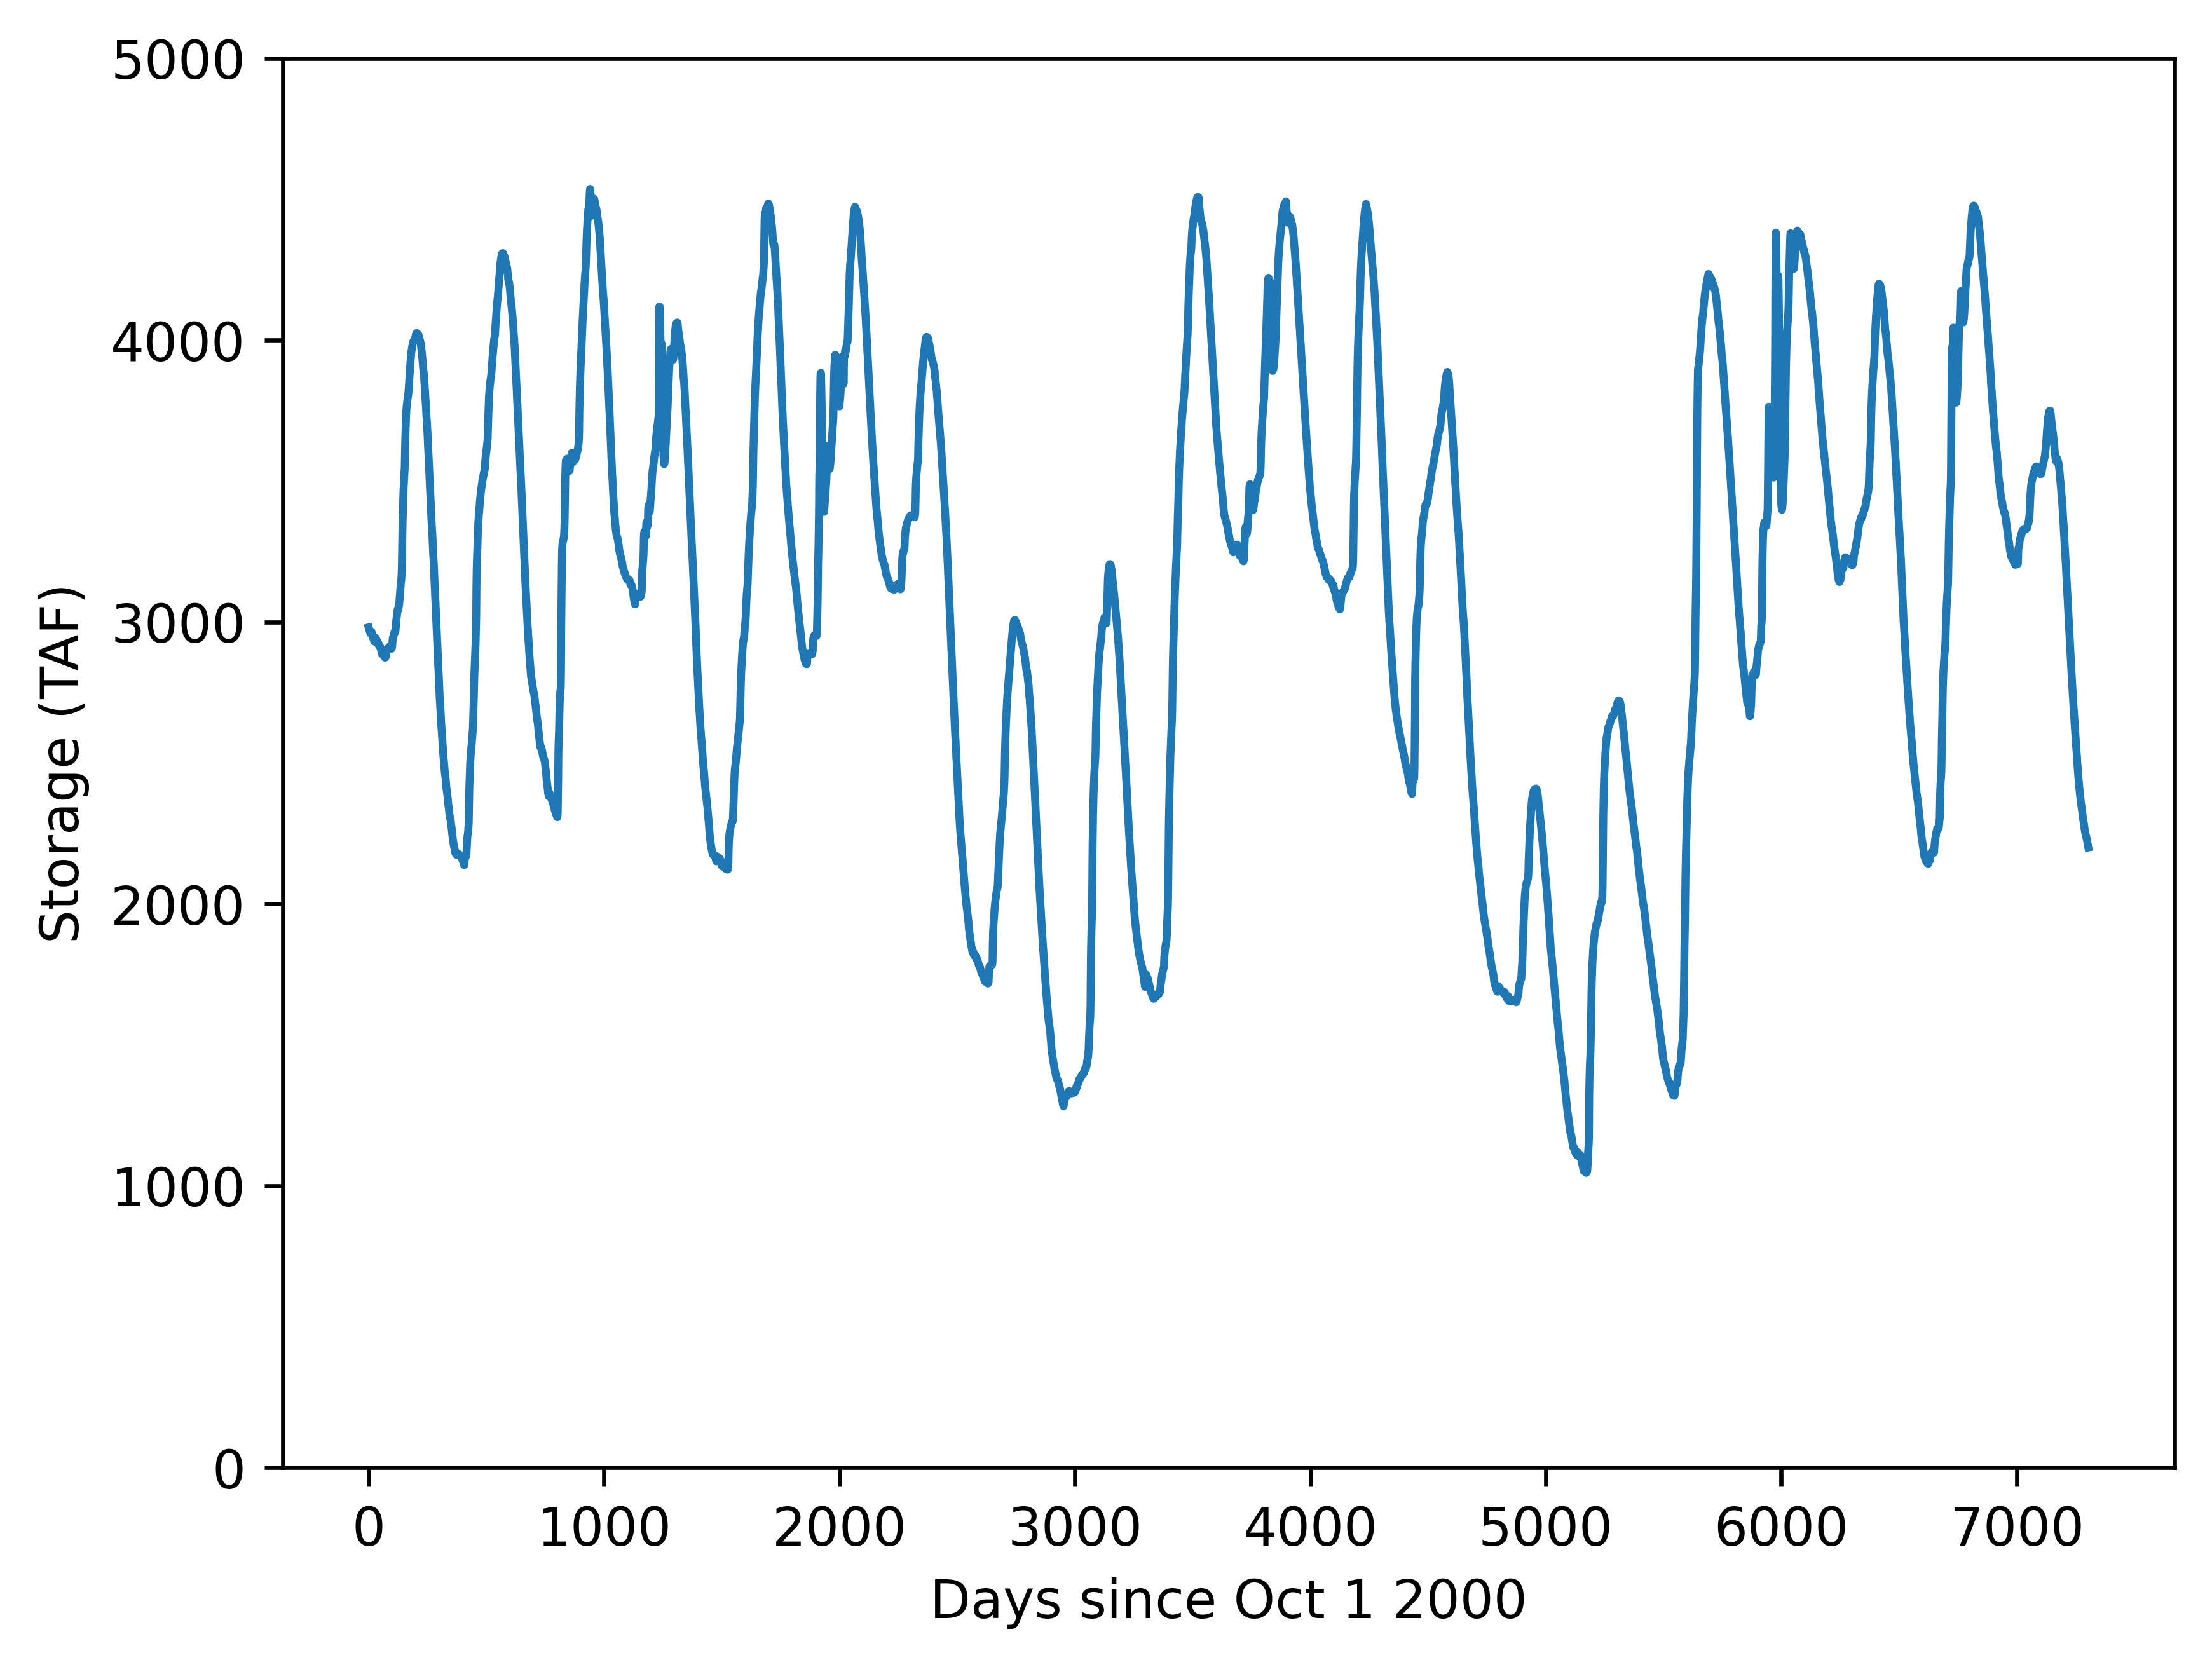

In [5]:
plt.plot(storage)
plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Storage (TAF)')
plt.ylim([0,5000])
plt.show()

#### Second plot: time series of inflow and outflow

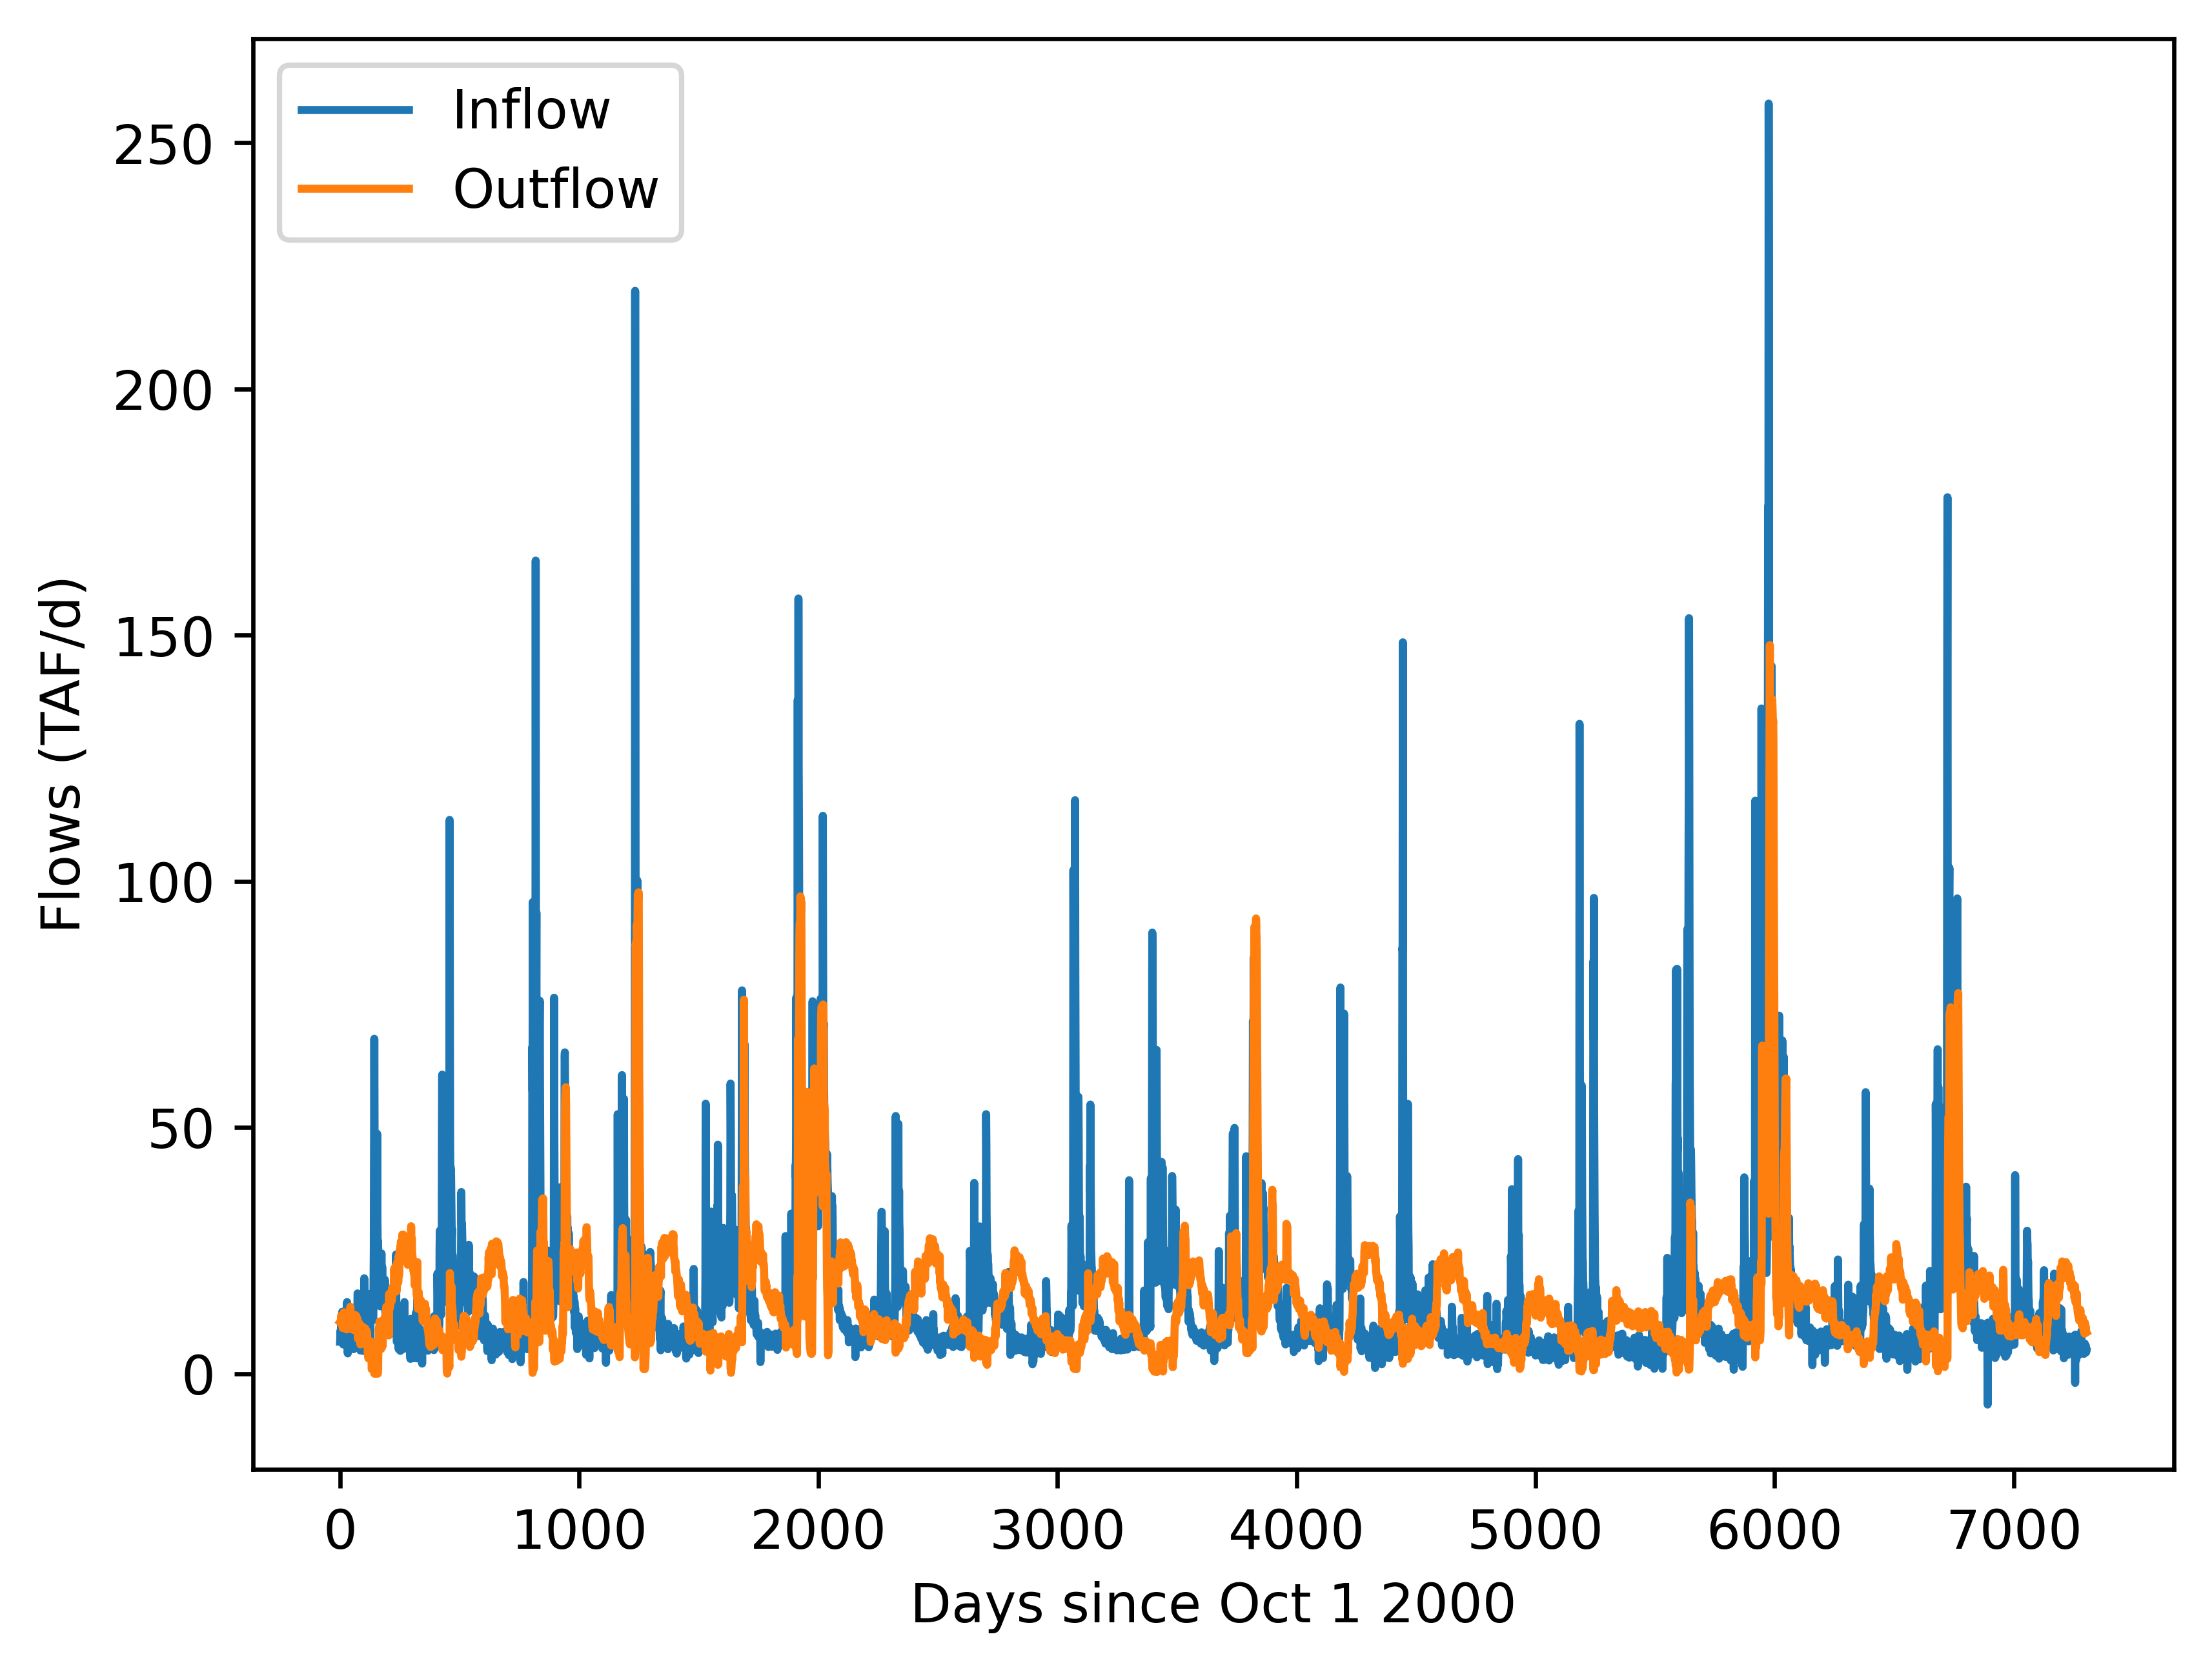

In [6]:
plt.plot(inflow)
plt.plot(outflow)
plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Flows (TAF/d)')
plt.legend(['Inflow', 'Outflow'])
plt.show()

#### Third plot: exceedance plot of inflow and outflow

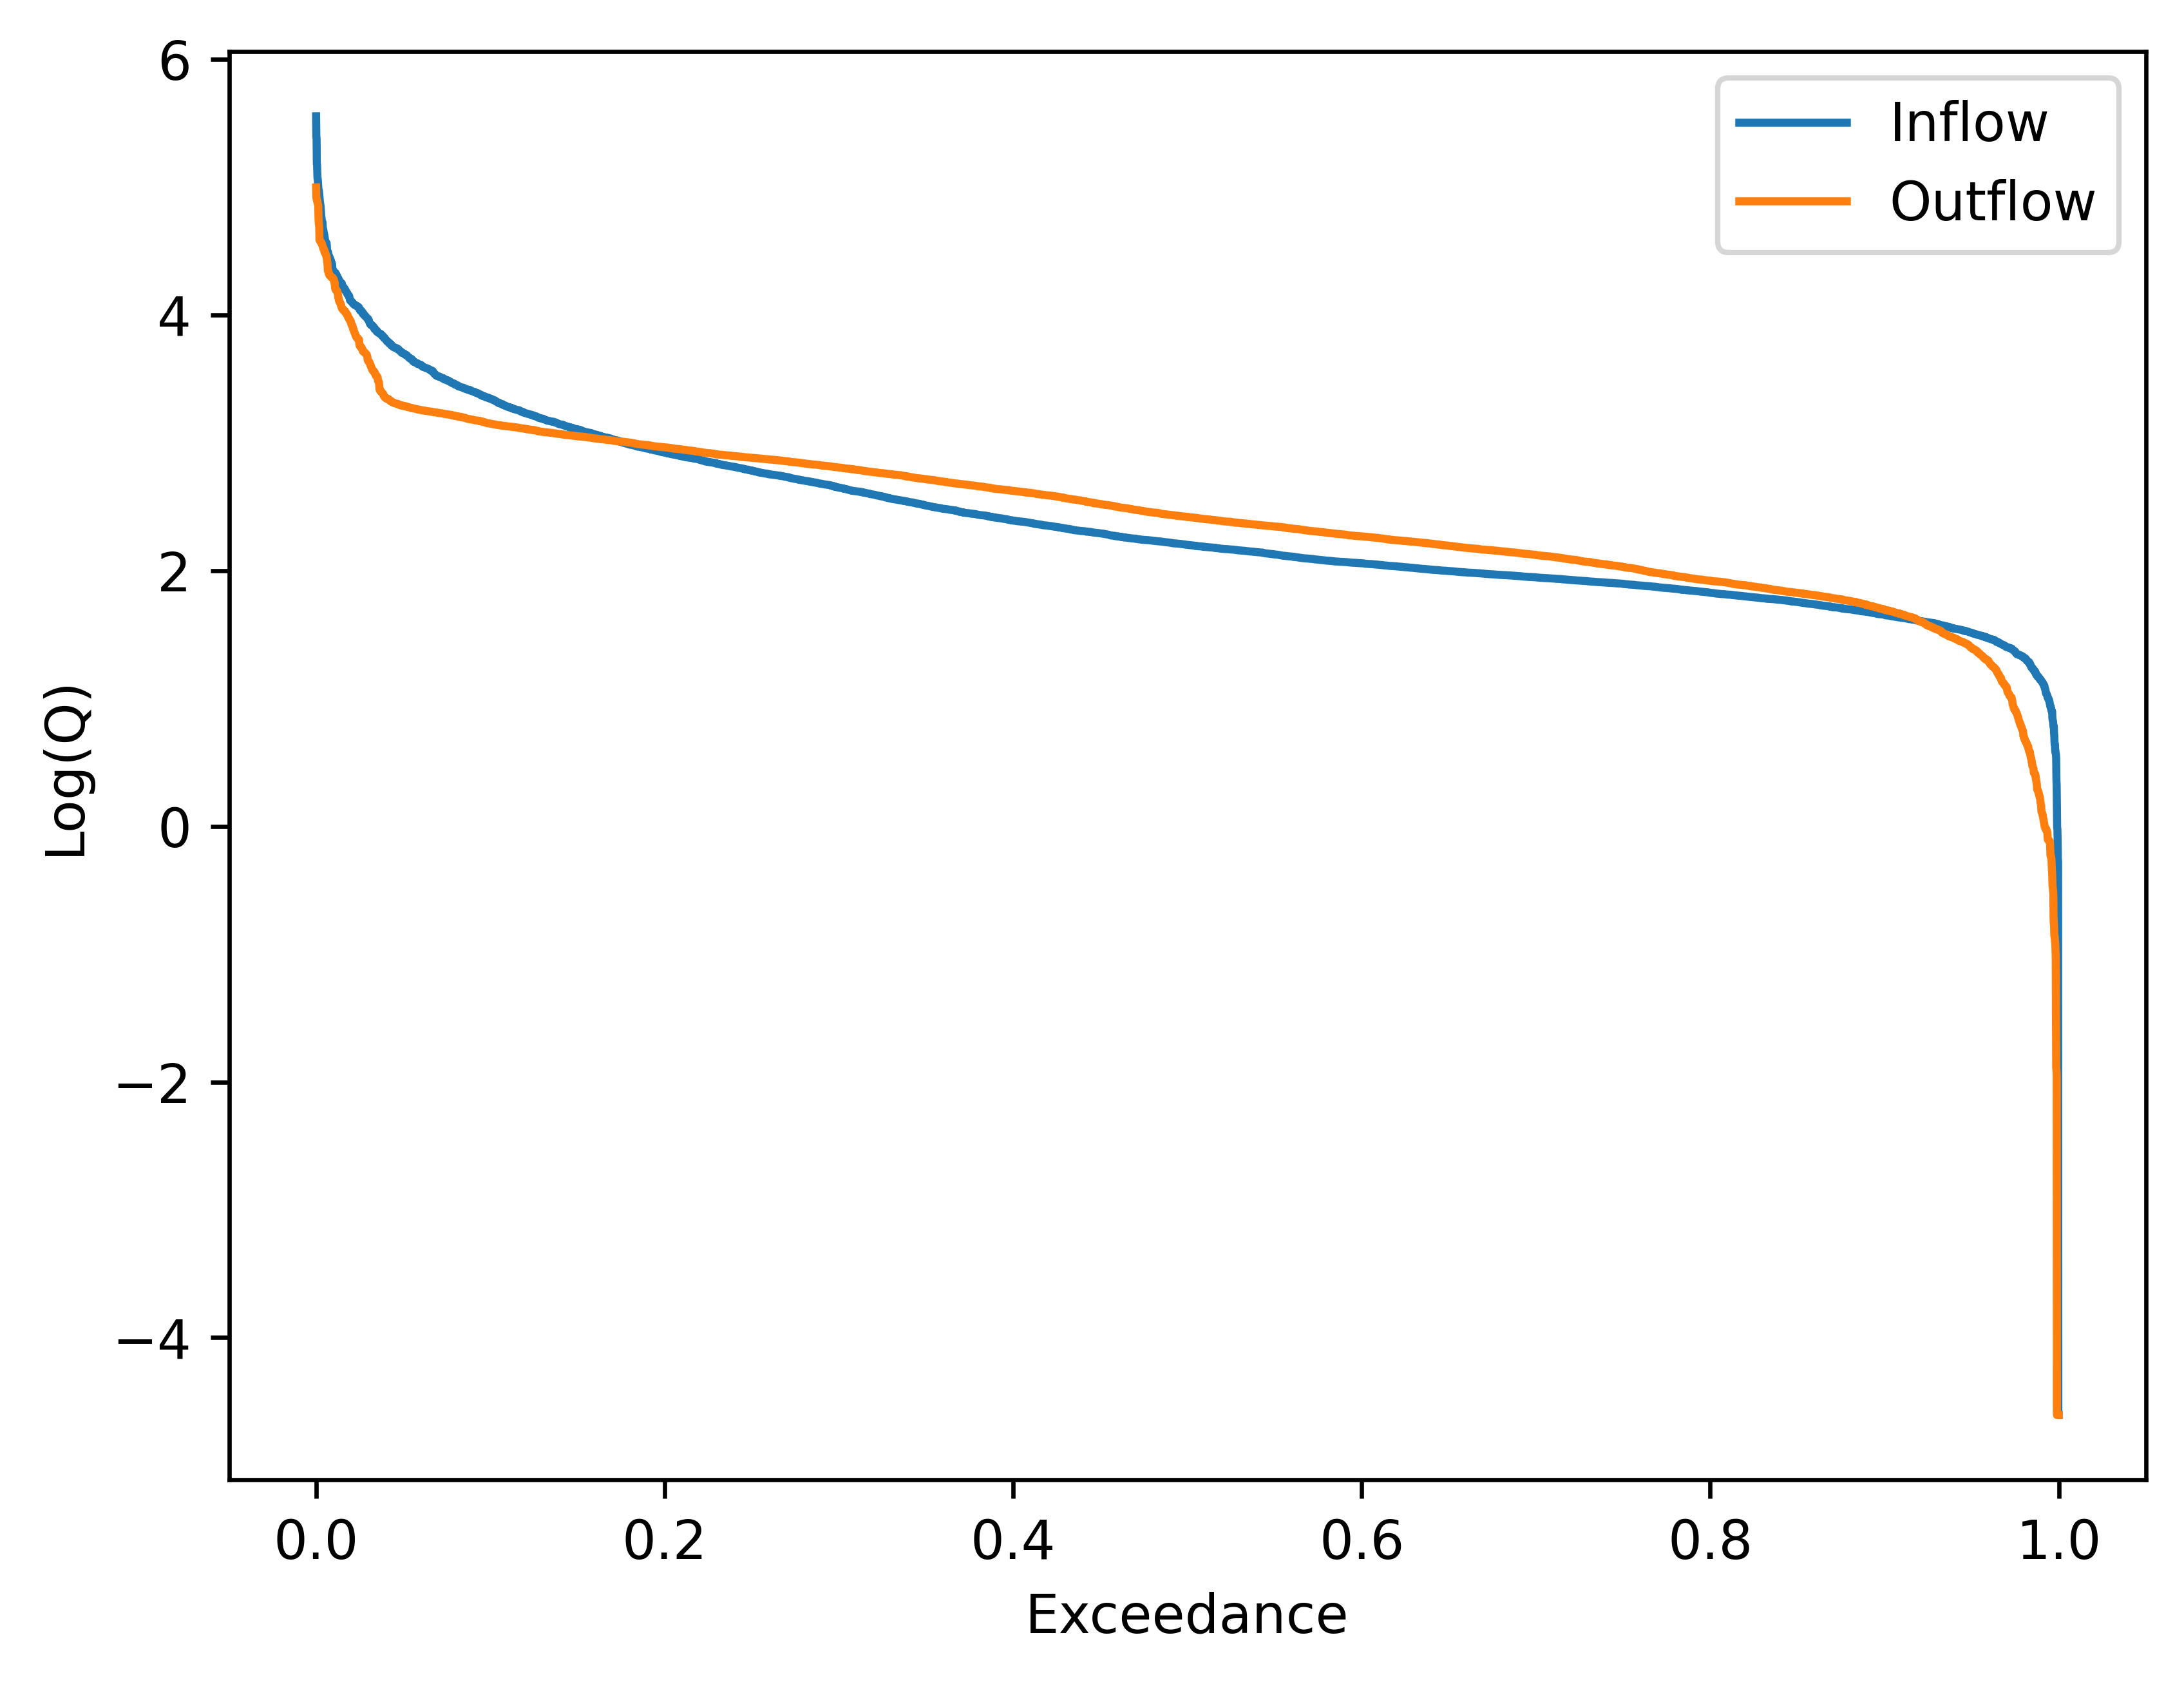

In [7]:
T = len(inflow)

# before log-transforming, replace ~zeros with small values to avoid warning
inflow[inflow < 0.01] = 0.01
outflow[outflow < 0.01] = 0.01
log_inflow = np.log(inflow)
log_outflow = np.log(outflow)

plt.plot(np.arange(T)/T, np.sort(log_inflow)[::-1])
plt.plot(np.arange(T)/T, np.sort(log_outflow)[::-1])
plt.legend(['Inflow', 'Outflow'])
plt.ylabel('Log(Q)')
plt.xlabel('Exceedance')
plt.show()

#### Fourth plot: historical storage for Folsom, Oroville, and Shasta

Plot on the same graph

In [8]:
reservoirs = ['FOL', 'ORO', 'SHA']

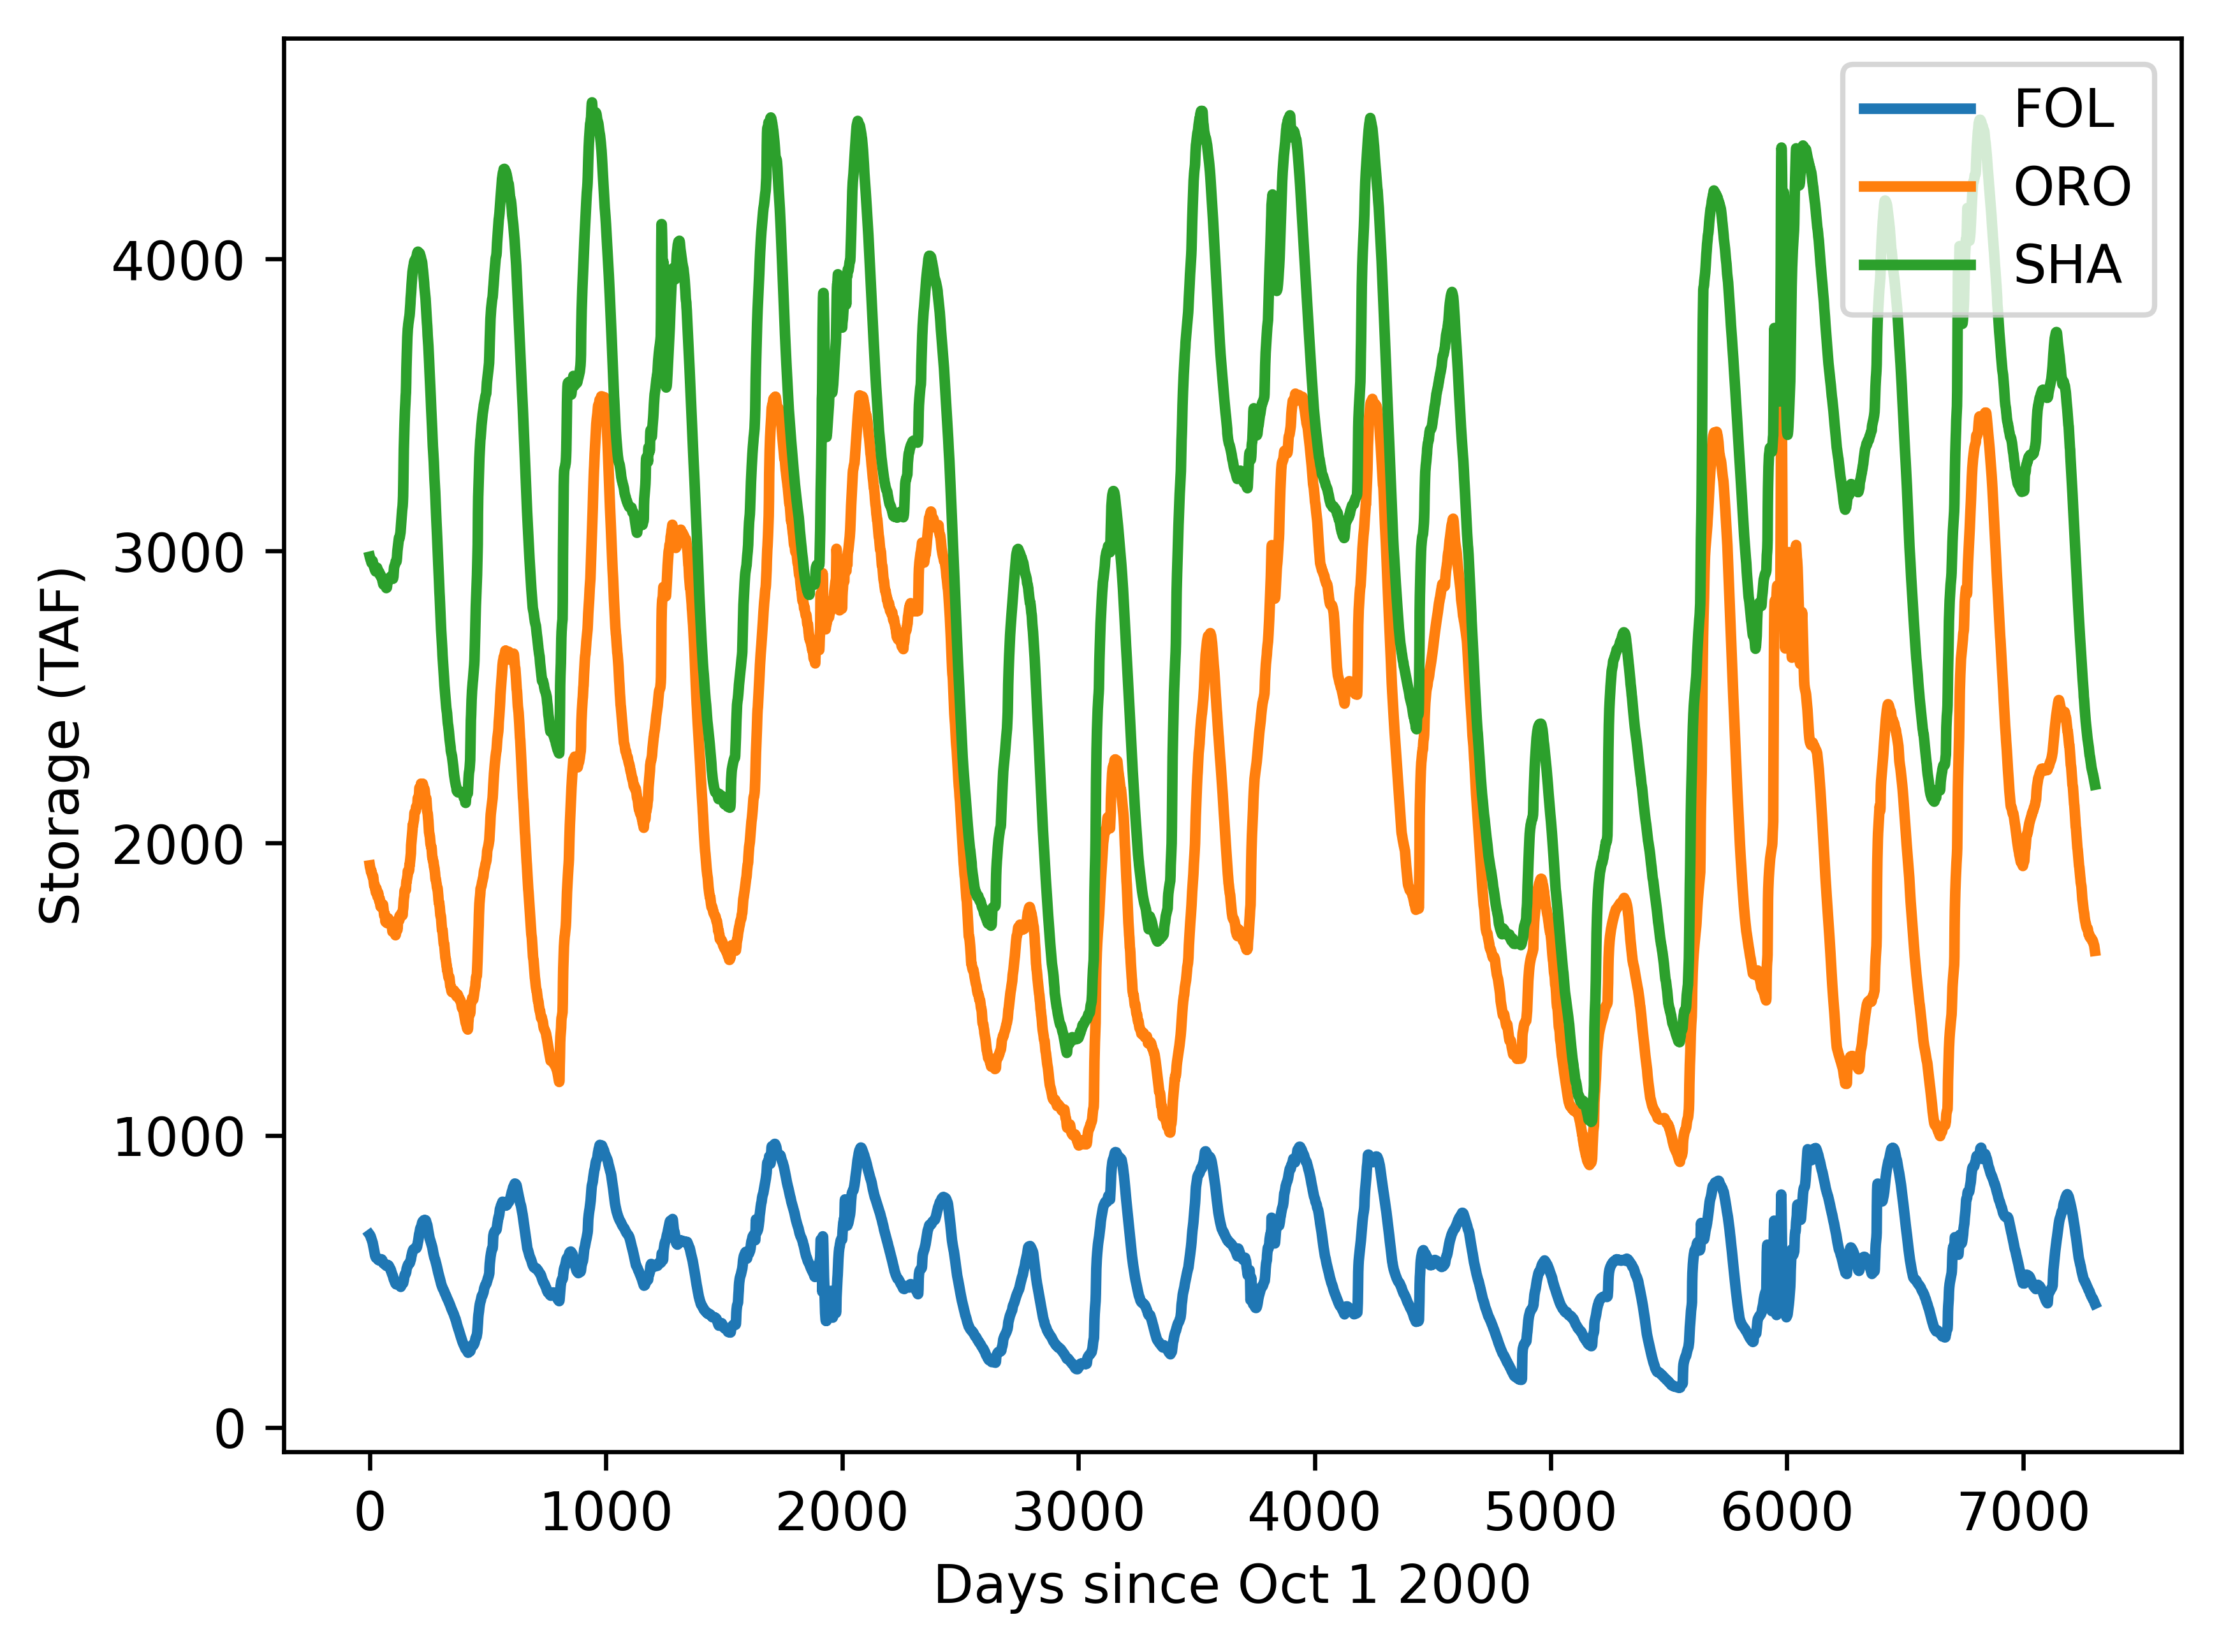

In [9]:
for r in reservoirs:
    data = np.loadtxt('data/' + r + '.csv', 
                    delimiter=',', 
                    skiprows=1, 
                    usecols=[1,2,3])
    
    storage = data[:,2] / 1000 # AF to TAF
    plt.plot(storage, linewidth=2)

plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Storage (TAF)')
plt.legend(reservoirs)

# optional - save to file
# plt.savefig('something.png') # or .pdf, .svg, etc.
plt.show()

-------------------

## Simulation model

Mass balance reservoir simulation with constant demand and standard operating policy.

In [10]:
K = 975 # capacity, TAF
D = 5 # target demand, TAF/day

Data setup:

In [11]:
Q = np.loadtxt('data/FOL.csv', delimiter=',', 
                skiprows=1, usecols=[1])
Q = Q * cfs_to_tafd
T = len(Q)

S = np.zeros(T)
R = np.zeros(T)
shortage = np.zeros(T)

S[0] = K/2 # start simulation half full
R[0] = D # first day meets demand

In [12]:
met_demand = 1 # reset counter

for t in range(1,T):

  # new storage: mass balance, max value is K
  S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

  # release is based on demand
  if S[t] + Q[t] > D:
    R[t] = D
    met_demand = met_demand + 1
  else:
    R[t] = S[t] + Q[t]

  shortage[t] = D-R[t]

reliability = met_demand / T
print('The reliability is %0.2f' % reliability)

The reliability is 0.91


Plot storage, inflow, outflow, and shortage as subplots

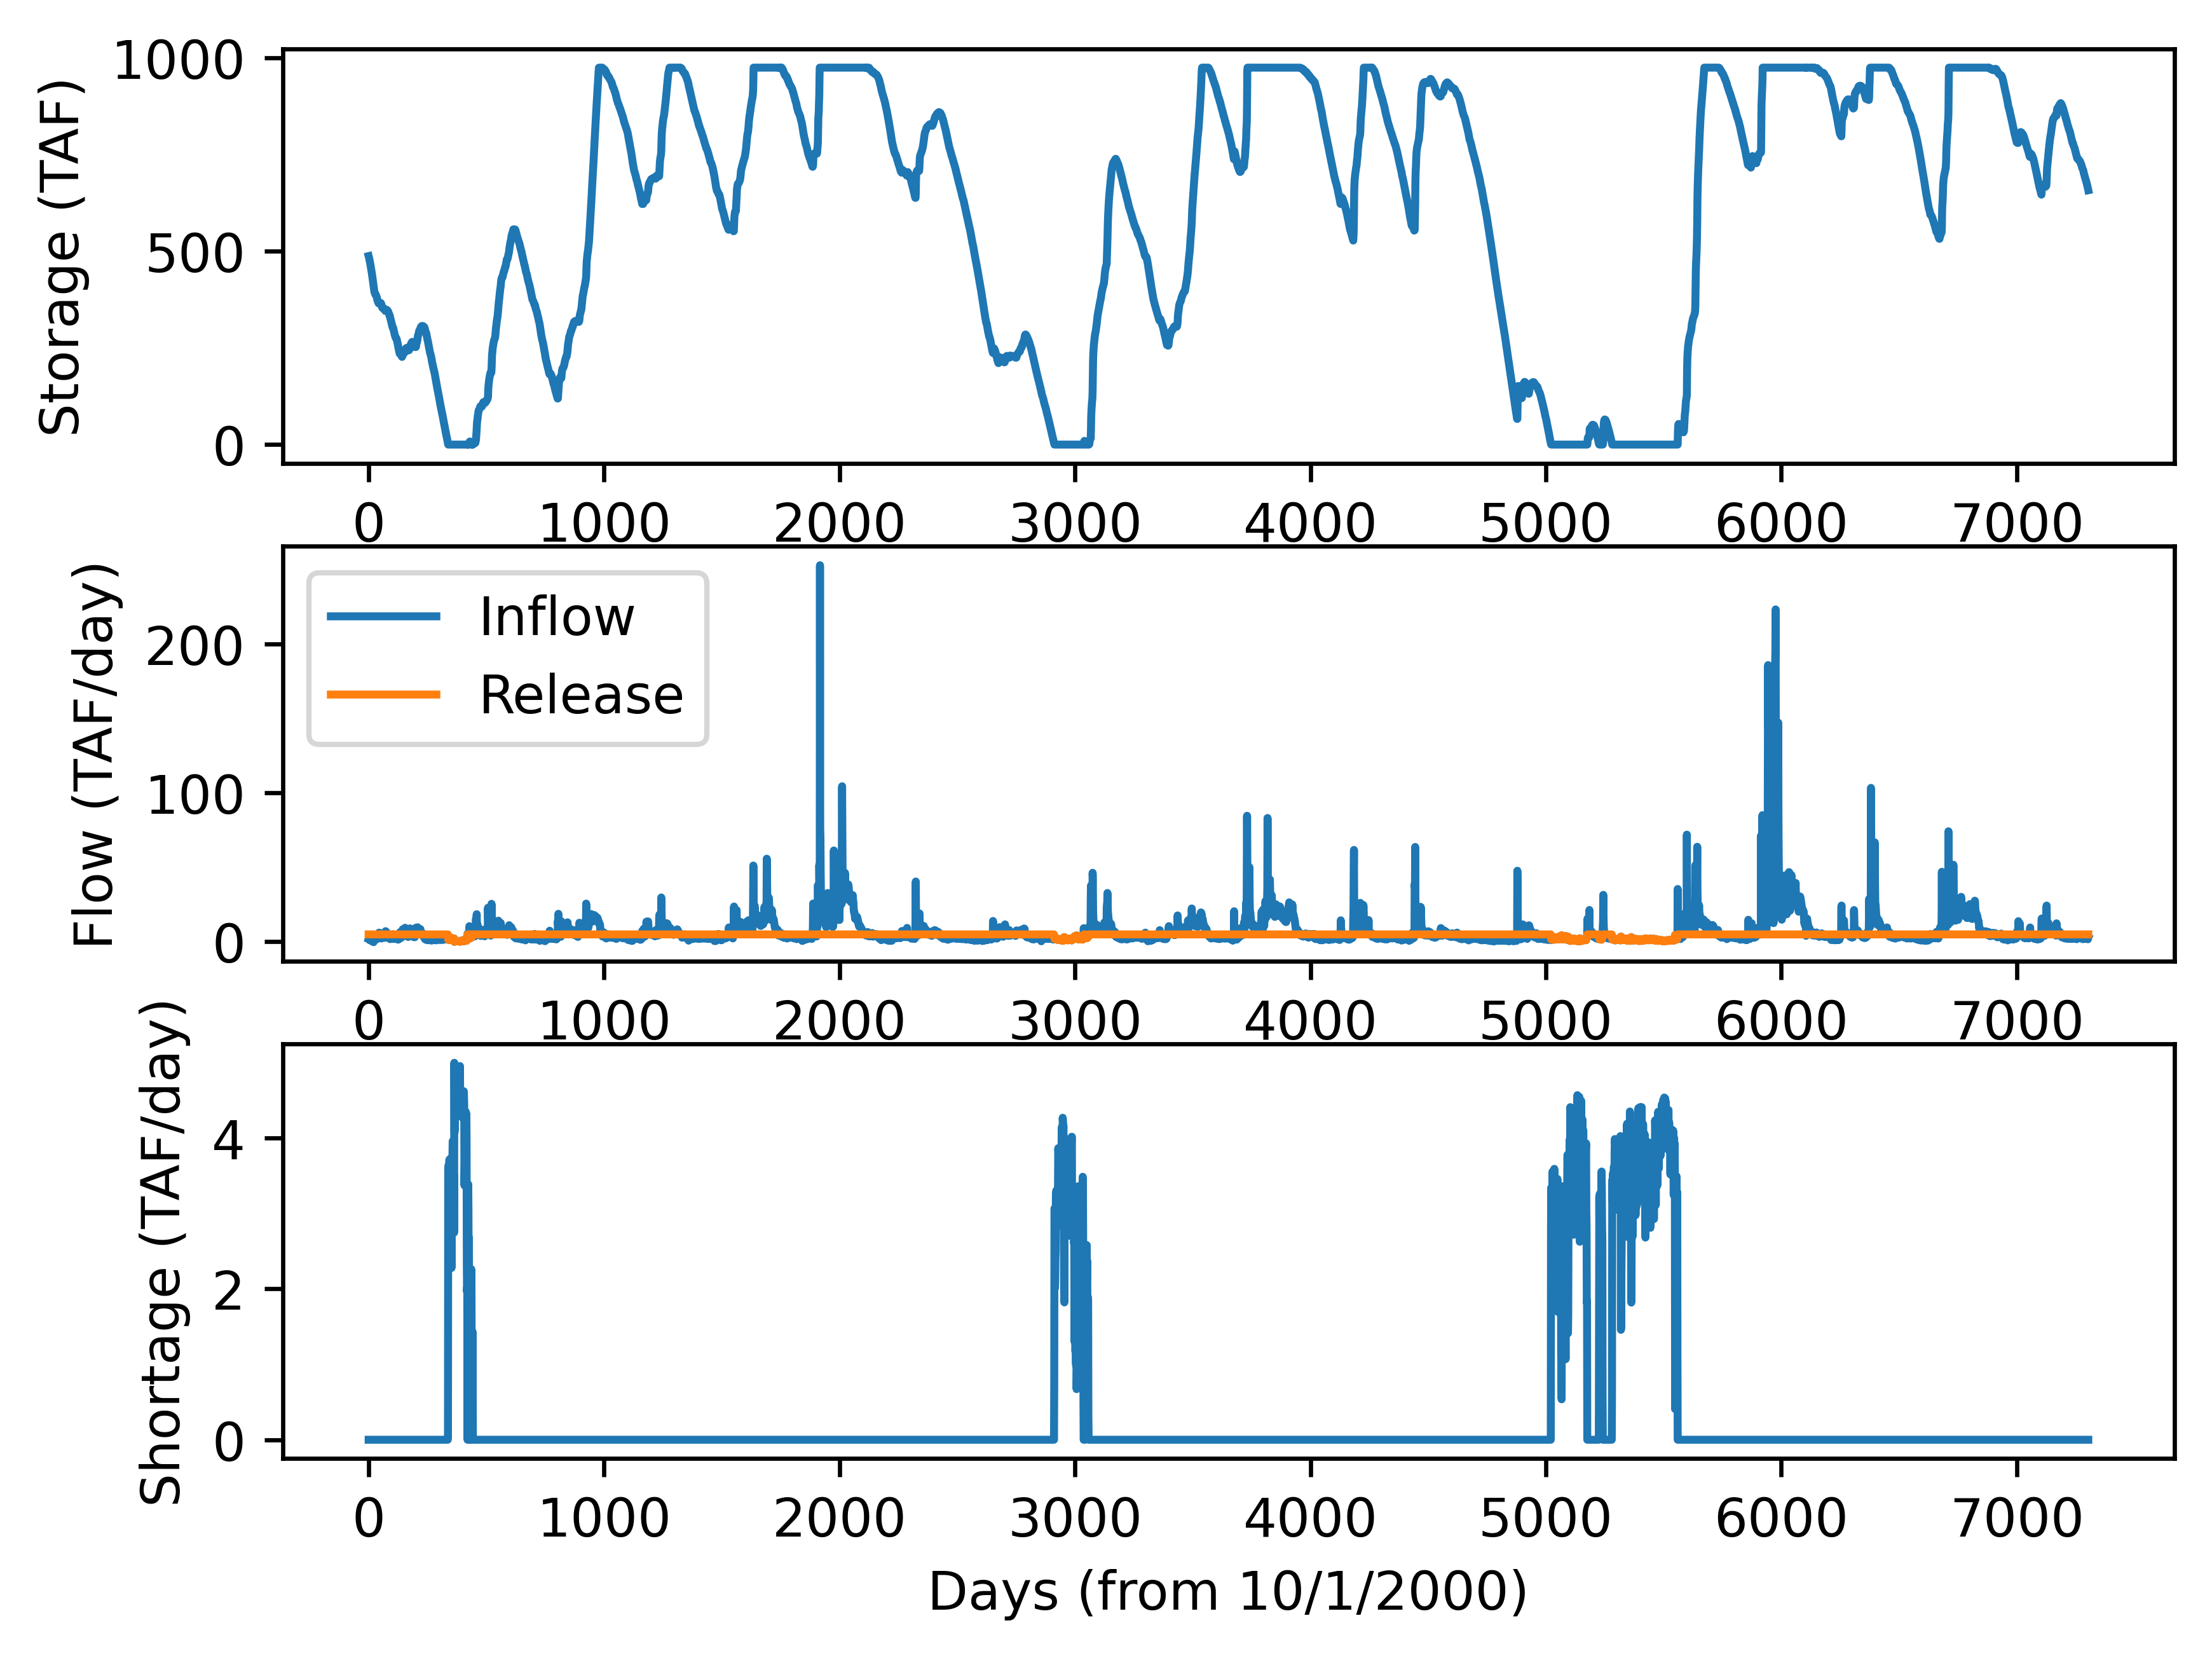

In [13]:
plt.subplot(3,1,1)
plt.plot(S)
plt.ylabel('Storage (TAF)')

plt.subplot(3,1,2)
plt.plot(Q)
plt.plot(R)
plt.legend(['Inflow', 'Release'])
plt.ylabel('Flow (TAF/day)')

plt.subplot(3,1,3)
plt.plot(shortage)
plt.ylabel('Shortage (TAF/day)')
plt.xlabel('Days (from 10/1/2000)')

plt.show()

------------

**Extensions:** CDEC data scraper (see script `cdec_scraper.py` in this directory)

This script works with pandas dataframes instead of Numpy arrays. We will talk more about dataframes in Lecture 5.

In [20]:
from cdec_scraper import cdec_sensor_data

df = cdec_sensor_data('ORO', 15, 'D', sd='2000-10-01', ed='2025-04-02')
# returns a pandas dataframe
print(df)

            ORO_STORAGE_AF
datetime                  
2000-10-01       1923917.0
2000-10-02       1918372.0
2000-10-03       1915194.0
2000-10-04       1912634.0
2000-10-05       1909361.0
...                    ...
2025-03-29       2994333.0
2025-03-30       3004810.0
2025-03-31       3023419.0
2025-04-01       3039815.0
2025-04-02             NaN

[8950 rows x 1 columns]


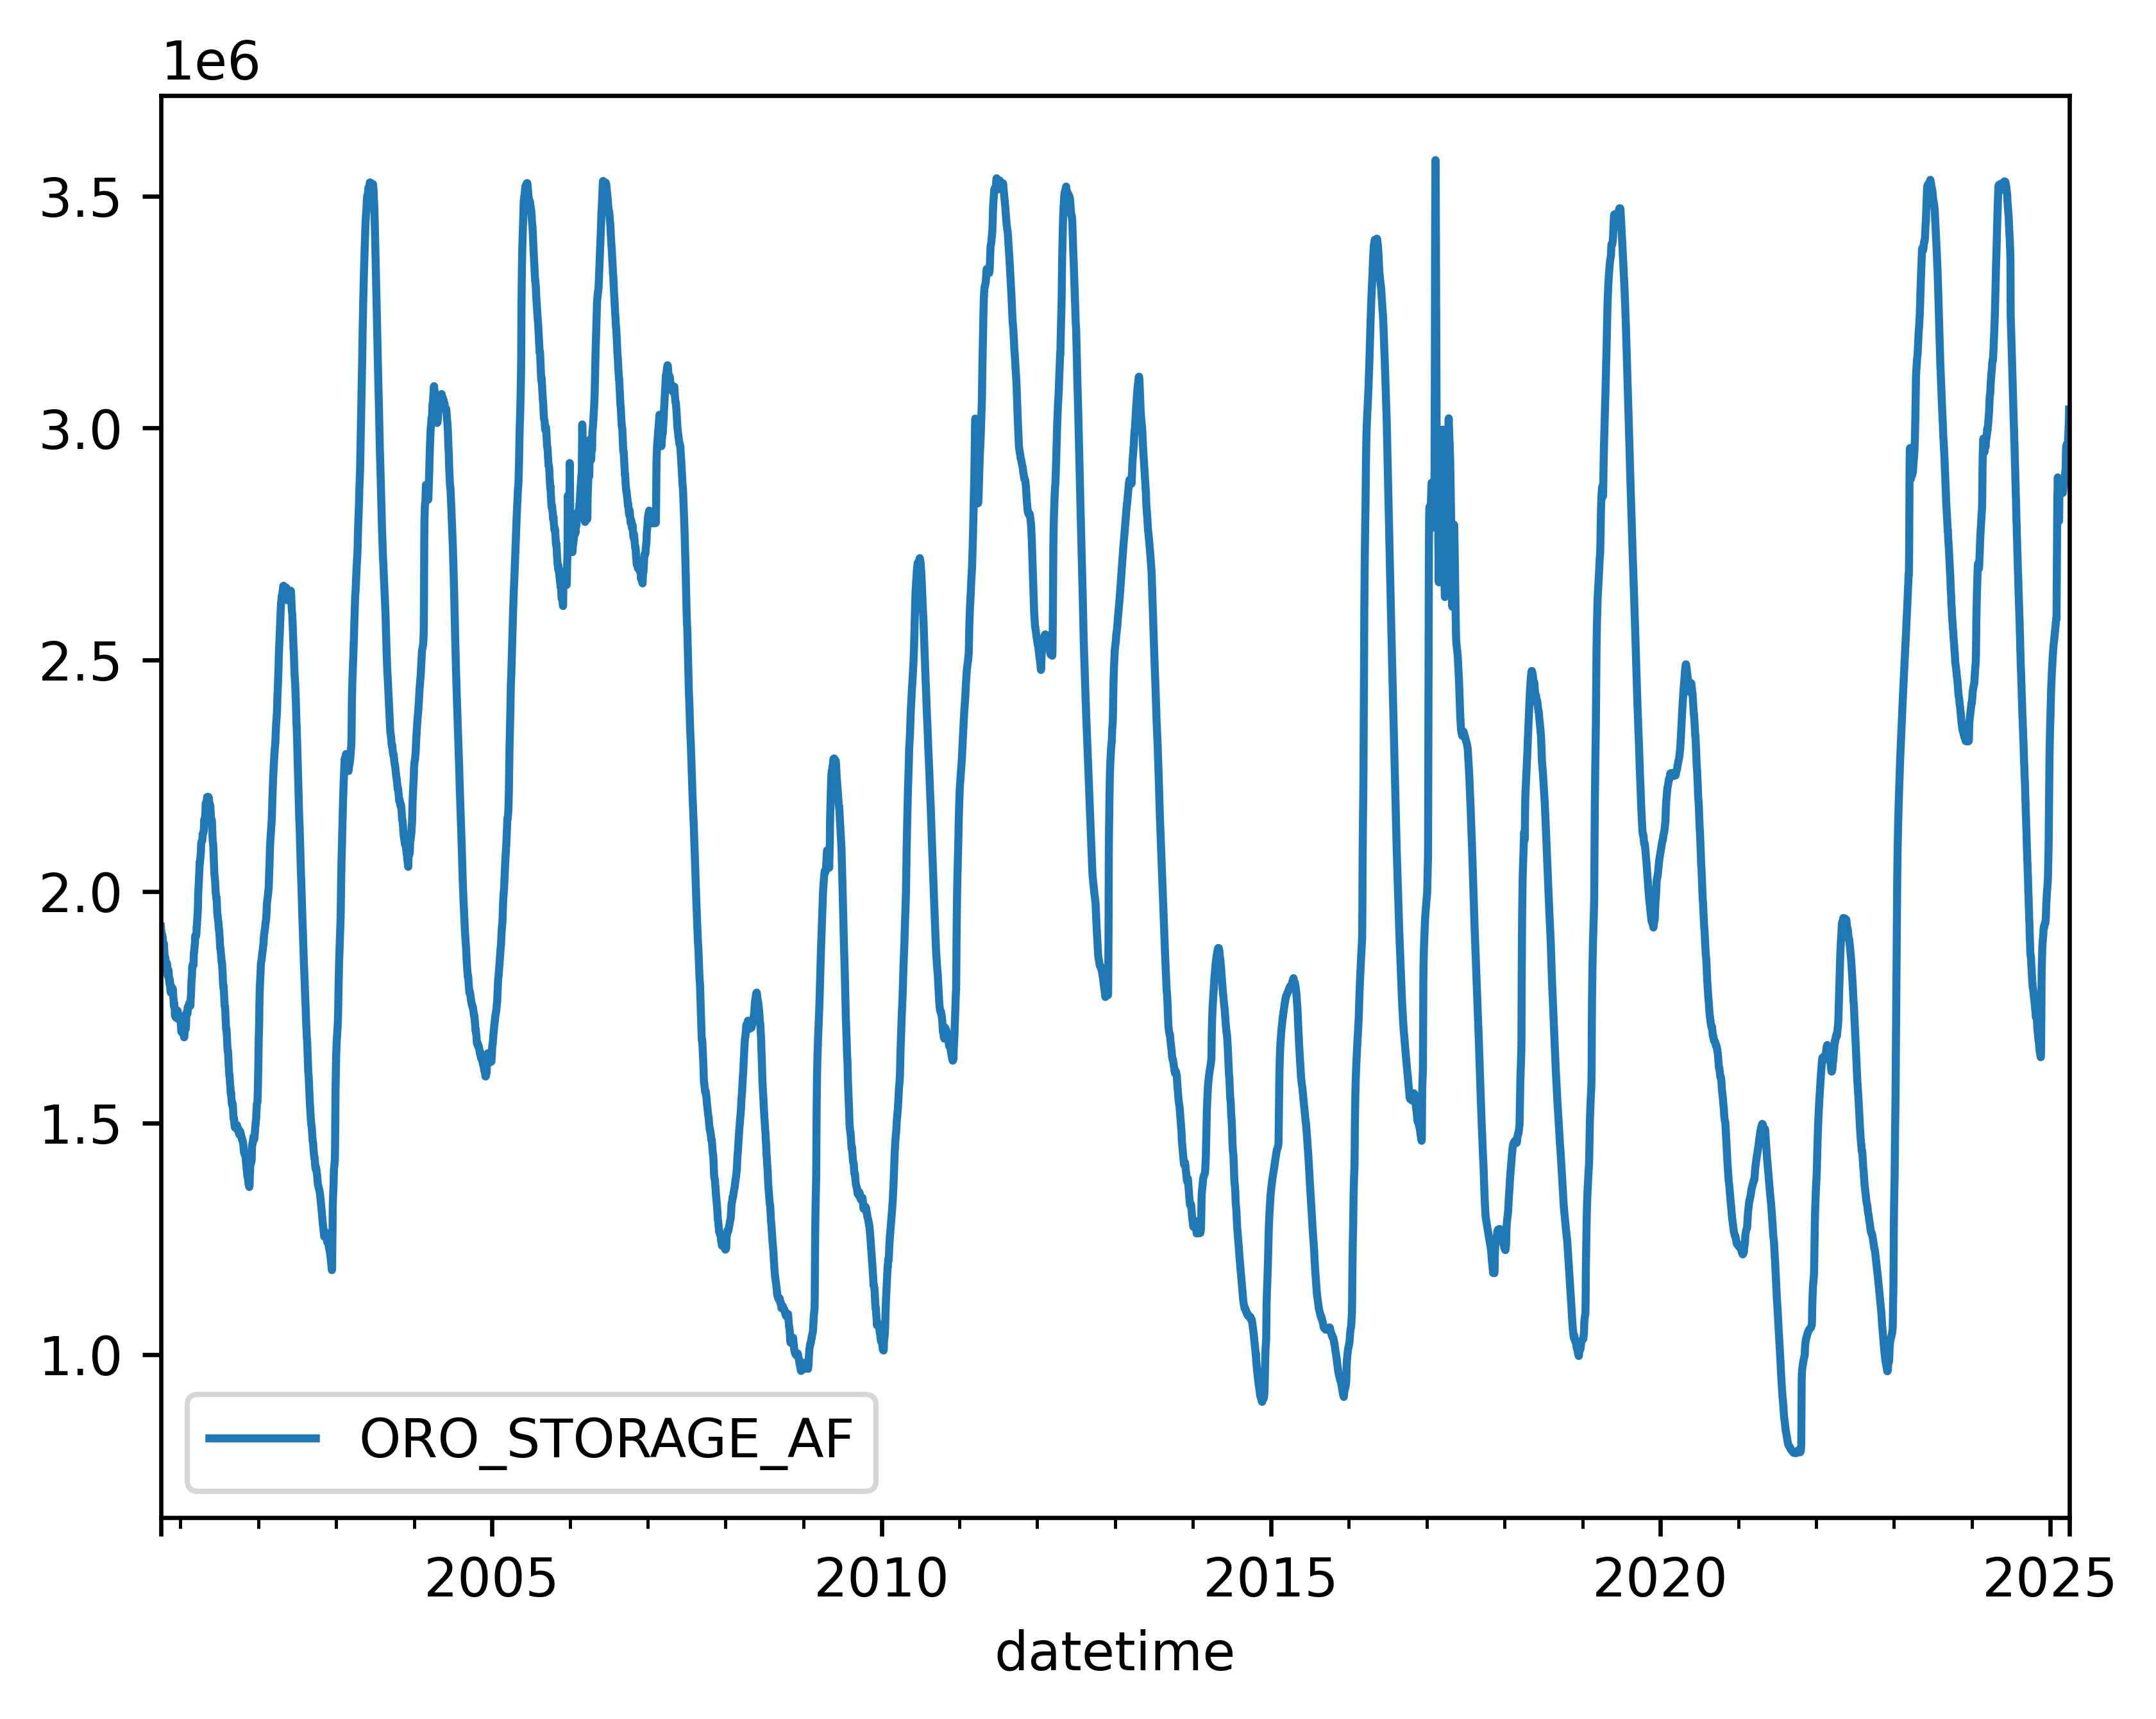

In [21]:
df.plot()
plt.show()

In [22]:
# convert from pandas to numpy array
SHA_storage = df.values
print(type(SHA_storage))

<class 'numpy.ndarray'>


In [24]:
# check for missing values
# .isna() returns array of booleans
print(df[df.ORO_STORAGE_AF.isna()])

            ORO_STORAGE_AF
datetime                  
2021-04-17             NaN
2025-04-02             NaN


In [25]:
# fill missing values (careful)
# fixed value
df_filled = df.fillna(0)
# interpolate
df_filled = df.interpolate()

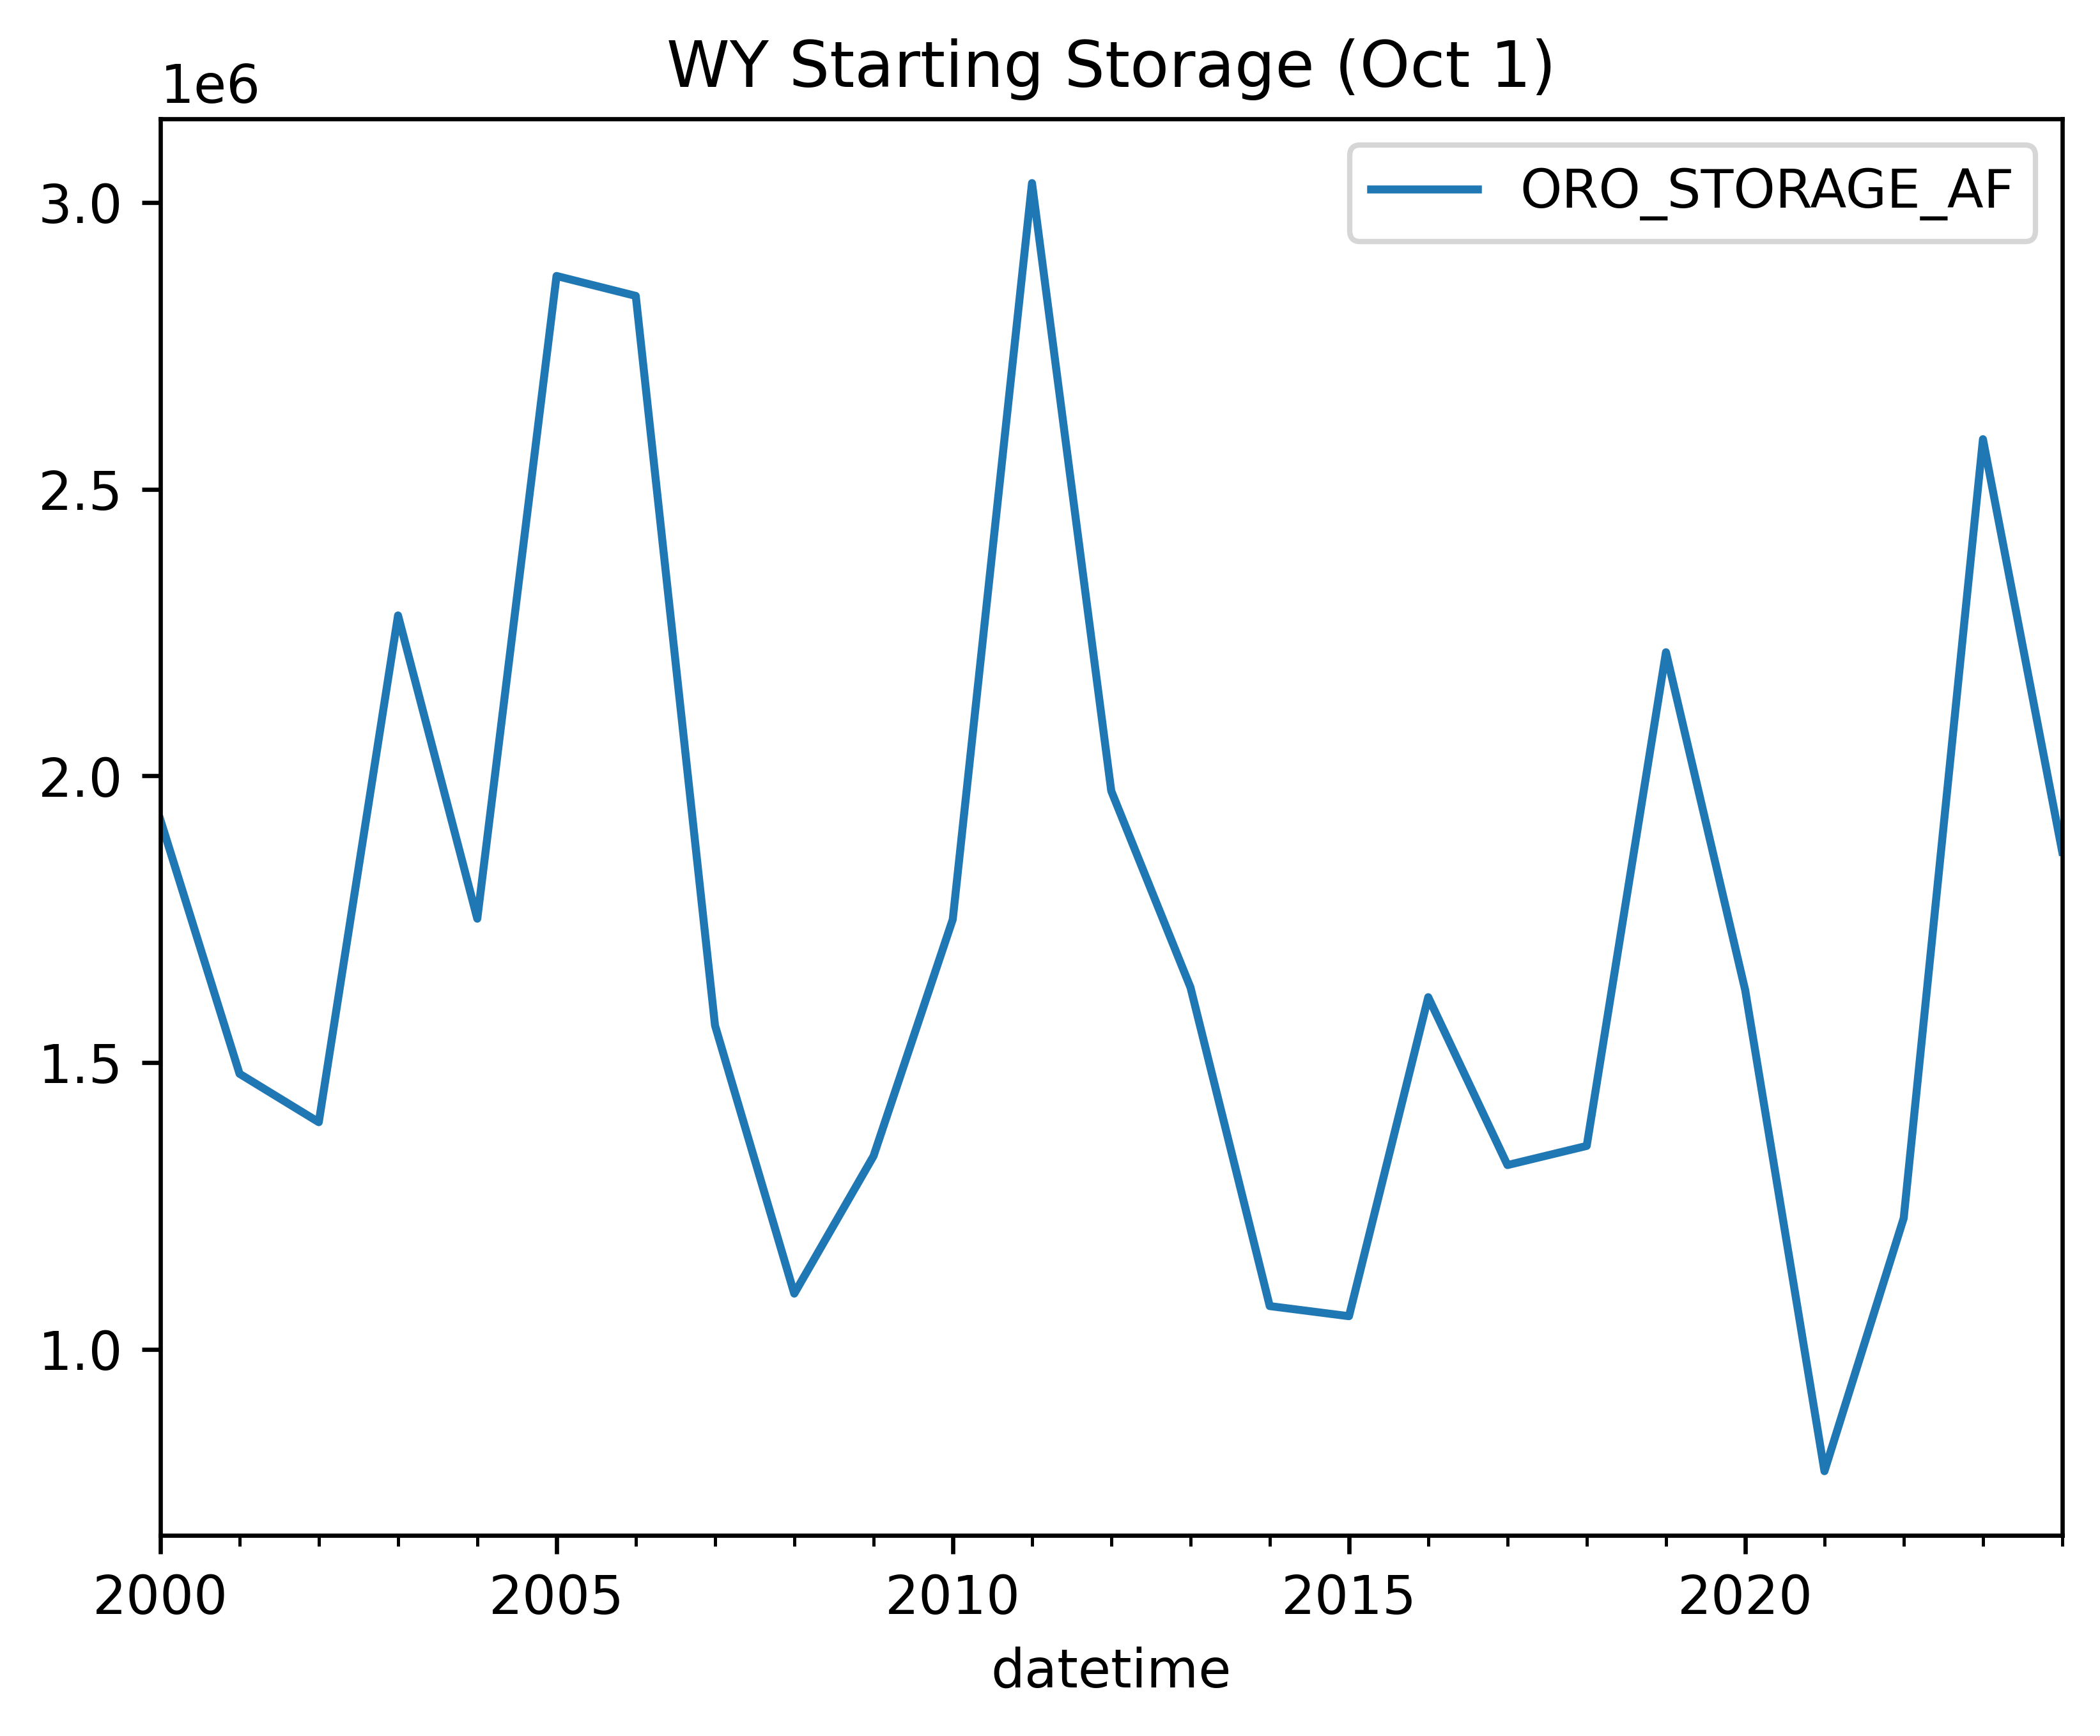

In [27]:
# resample from monthly to water year data
df_yearly = df.resample('YS-OCT').first()
df_yearly.plot()
plt.title('WY Starting Storage (Oct 1)')
plt.show()